## HDAT 9910 Capstone


Research Question 1: Mortality Prediction in ICU 

Task: The task is to build a predictive algorithm using the techniques we learned in this course. 

Objective: To assess the role of machine learning algorithms for predicting mortality by using the MIMIC-III dataset. 

Question: Is it possible to accurately predict mortality based on data from the first 24 hours in ICU?   

Study Population: MIMIC-III dataset 

#### Load packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import concurrent.futures


#### Load in the MIMIC-III Dataset

In [17]:
# Create a function to loads through all CSV files
def read_all_datasets(data_folder):
    
    datasets = {}

    csv_files = [
        'vitals_hourly.csv', 'admissions.csv', 'antibiotics.csv', 'bloodculture.csv',
        'gcs_hourly.csv', 'icd9_diag.csv', 'icustays.csv', 'labs_hourly.csv',
        'output_hourly.csv', 'patients.csv', 'pt_icu_outcome.csv', 'pt_stay_hr.csv',
        'pt_weight.csv', 'pv_mechvent.csv', 'transfers.csv', 'vasopressors.csv'
    ]

    for file in csv_files:
        file_path = os.path.join(data_folder, file)

        if os.path.exists(file_path):
            datasets[file.replace('.csv', '')] = pd.read_csv(file_path)
        else:
            print(f"File not found: {file}")

    return datasets

data_folder = '/Users/zacharylukac/Desktop/HDAT-9910-Capstone/mimic_data/'
all_datasets = read_all_datasets(data_folder)

# Assign all files to a dataframe for exploration
admissions_df = all_datasets['admissions']
vitals_hourly_df = all_datasets['vitals_hourly']
antibiotics_df = all_datasets['antibiotics']
bloodculture_df = all_datasets['bloodculture']
gcs_hourly_df = all_datasets['gcs_hourly']
icd9_diag_df = all_datasets['icd9_diag']
icustays_df = all_datasets['icustays']
labs_hourly_df = all_datasets['labs_hourly']
pt_stay_hr_df = all_datasets['pt_stay_hr']
pt_icu_outcome_df = all_datasets['pt_icu_outcome']
patients_df = all_datasets['patients']
output_hourly_df = all_datasets['output_hourly']
pt_weight_df = all_datasets['pt_weight']
pv_mechvent_df = all_datasets['pv_mechvent']
transfers_df = all_datasets['transfers']
vasopressors_df = all_datasets['vasopressors']

### convert to 32bit to save memory

In [28]:
def convert_columns_to_32bit(dataframe, columns):
    for col in columns:
        if col in dataframe.columns:
            if dataframe[col].dtype == 'int64':
                dataframe[col] = dataframe[col].astype('int32')
            elif dataframe[col].dtype == 'float64':
                dataframe[col] = dataframe[col].astype('float32')
    return dataframe


vitals_hourly_columns = ['icustay_id', 'hr', 'spo2', 'fio2', 'temperature', 'resprate', 'heartrate', 'sysbp', 'diasbp', 'glucose', 'meanarterialpressure']
labs_hourly_columns = ['icustay_id', 'hr', 'neutrophil', 'creactiveprotein', 'whitebloodcell', 'partialpressureo2', 'bicarbonate', 'lactate', 'troponin', 'bloodureanitrogen', 'creatinine', 'alaninetransaminase', 'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio', 'platelets', 'albumin', 'chloride', 'glucose', 'sodium', 'bilirubin', 'hematocrit']
pt_icu_outcome_columns = ['row_id', 'subject_id', 'dob', 'hadm_id', 'admittime', 'dischtime', 'icustay_id', 'age_years', 'intime', 'outtime', 'los', 'hosp_deathtime', 'icu_expire_flag', 'hospital_expire_flag', 'dod', 'expire_flag', 'ttd_days']
gcs_hourly_columns = ['icustay_id', 'hr', 'gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag']
pt_weight_columns = ['icustay_id', 'dy','starttime','endtime', 'admissionweight', 'dailyweight','previousweight','echoweight', 'avg_weight_naive', 'min_weight', 'max_weight']
output_hourly_columns = ['icustay_id', 'hr','urineoutput']


vitals_hourly_df = convert_columns_to_32bit(vitals_hourly_df, vitals_hourly_columns)
labs_hourly_df = convert_columns_to_32bit(labs_hourly_df, labs_hourly_columns)
pt_icu_outcome_df = convert_columns_to_32bit(pt_icu_outcome_df, pt_icu_outcome_columns)
gcs_hourly_df = convert_columns_to_32bit(gcs_hourly_df, gcs_hourly_columns)
pt_weight_df = convert_columns_to_32bit(pt_weight_df, pt_weight_columns)
output_hourly_df = convert_columns_to_32bit(output_hourly_df, output_hourly_columns)

## Explore variables relating to the research question

#### vitals hourly levels for alive vs dead patients

In [ ]:
df = pd.merge(pt_icu_outcome_df, vitals_hourly_df, on="icustay_id", how="inner")
df = df[df.filter(regex='^(?!.*_y)').columns]
df.columns = df.columns.str.replace('_x', '')

In [ ]:
died_data = df[df['icu_expire_flag'] == 1]
alive_data = df[df['icu_expire_flag'] == 0]
column_names = ['spo2', 'fio2', 'temperature', 'resprate', 'heartrate', 'sysbp', 
                'diasbp', 'glucose', 'meanarterialpressure']
sampled_alive_data = alive_data.sample(frac=0.01, random_state=42)


In [ ]:
# EDA for the features
for column in column_names:
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution for each group
    sns.histplot(died_data[column].dropna(), kde=True, label='Died', color='blue')
    sns.histplot(sampled_alive_data[column].dropna(), kde=True, label='Alive', color='red')
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

#### labs hourly levels for alive vs dead patients

In [ ]:
df2 = pd.merge(pt_icu_outcome_df, labs_hourly_df, on="icustay_id", how="inner")
df2 = df2[df2.filter(regex='^(?!.*_y)').columns]
df2.columns = df2.columns.str.replace('_x', '')

In [ ]:
died_data2 = df2[df2['icu_expire_flag'] == 1]
alive_data2 = df2[df2['icu_expire_flag'] == 0]
column_names2 = ['neutrophil','creactiveprotein', 'whitebloodcell', 'partialpressureo2', 'bicarbonate',
    'lactate', 'troponin', 'bloodureanitrogen', 'creatinine', 'alaninetransaminase',
    'aspartatetransaminase', 'hemoglobin', 'intnormalisedratio', 'platelets',
    'albumin', 'chloride', 'sodium', 'bilirubin', 'hematocrit']
sampled_alive_data2 = alive_data2.sample(frac=0.01, random_state=42)


In [ ]:
# EDA for the features
for column in column_names2:
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution for each group
    sns.histplot(died_data2[column].dropna(), kde=True, label='Died', color='blue')
    sns.histplot(sampled_alive_data2[column].dropna(), kde=True, label='Alive', color='red')
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

#### GCS hourly levels for alive vs dead patients

In [5]:
df3 = pd.merge(pt_icu_outcome_df, gcs_hourly_df, on="icustay_id", how="inner")
df3 = df3[df3.filter(regex='^(?!.*_y)').columns]
df3.columns = df3.columns.str.replace('_x', '')

In [6]:
died_data3 = df3[df3['icu_expire_flag'] == 1]
alive_data3 = df3[df3['icu_expire_flag'] == 0]
sampled_alive_data3 = alive_data3.sample(frac=0.01, random_state=42)

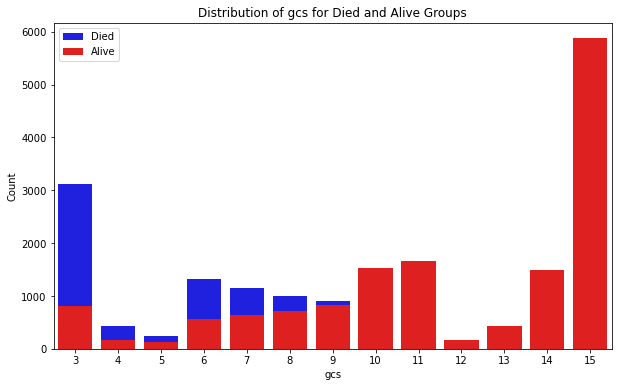

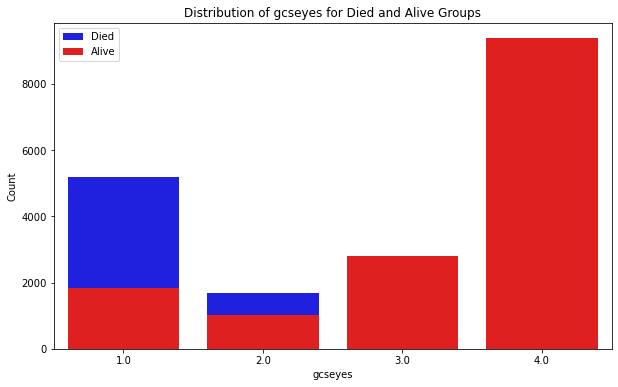

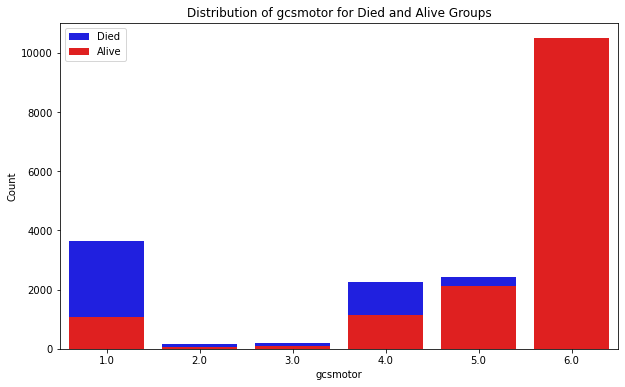

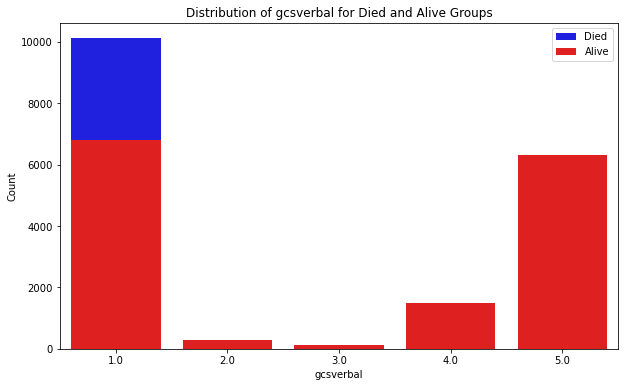

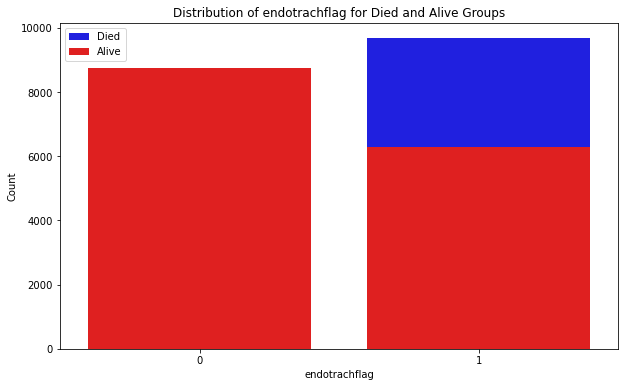

In [7]:
# EDA for the features

# Select categorical columns for visualization
categorical_columns = ['gcs', 'gcseyes', 'gcsmotor', 'gcsverbal', 'endotrachflag']

# EDA for categorical features
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Plot the count for each category in Died and Alive groups
    sns.countplot(x=column, data=died_data3, color='blue', label='Died')
    sns.countplot(x=column, data=sampled_alive_data3, color='red', label='Alive')
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend()
    plt.show()


### Patient weight for alive vs dead

In [20]:
df4 = pd.merge(pt_icu_outcome_df, pt_weight_df, on="icustay_id", how="inner")
df4 = df4[df4.filter(regex='^(?!.*_y)').columns]
df4.columns = df4.columns.str.replace('_x', '')

In [25]:
died_data4 = df4[df4['icu_expire_flag'] == 1]
alive_data4 = df4[df4['icu_expire_flag'] == 0]
column_names4 = ['admissionweight', 'dailyweight','previousweight','echoweight', 'avg_weight_naive', 'min_weight', 'max_weight']
sampled_alive_data4 = alive_data4.sample(frac=0.01, random_state=42)

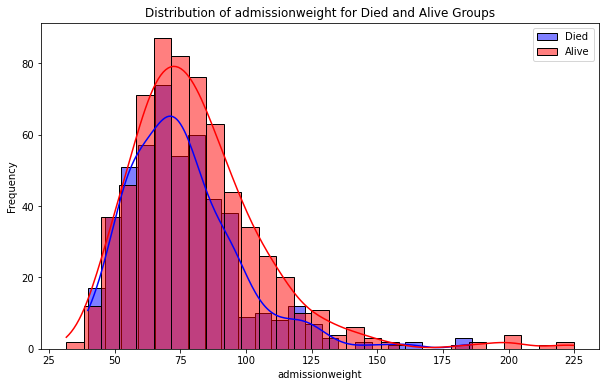

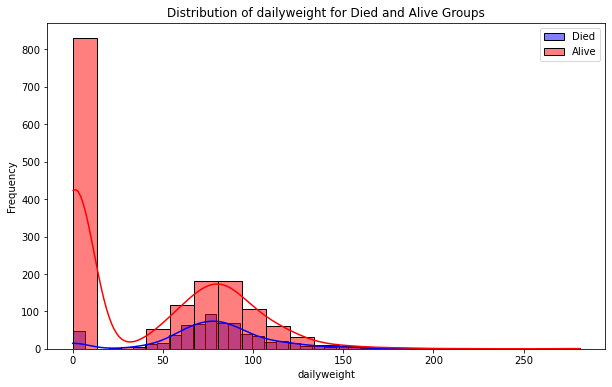

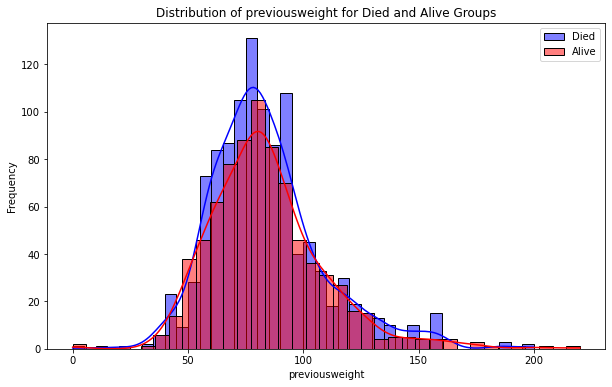

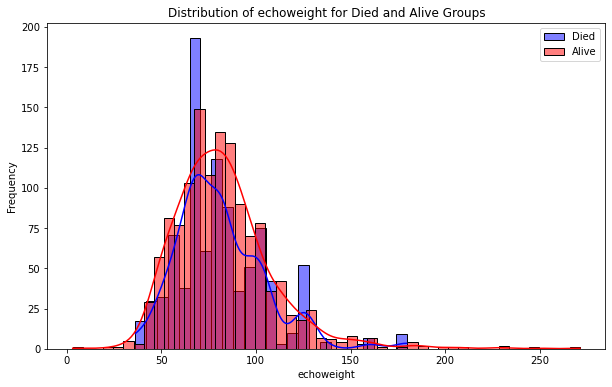

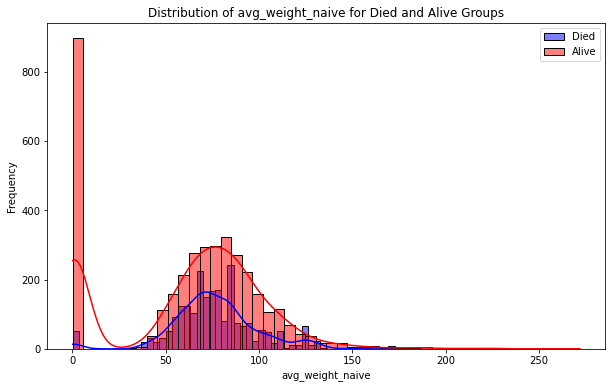

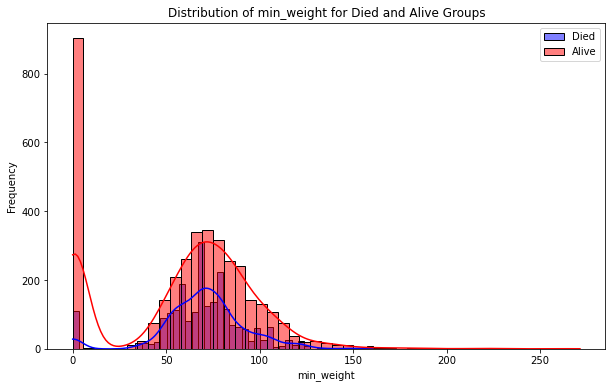

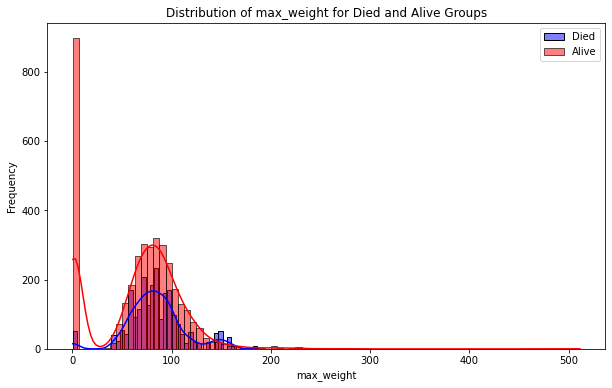

In [26]:
for column in column_names4:
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution for each group
    sns.histplot(died_data4[column].dropna(), kde=True, label='Died', color='blue')
    sns.histplot(sampled_alive_data4[column].dropna(), kde=True, label='Alive', color='red')
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

### output hourly dead vs alive

In [30]:
df5 = pd.merge(pt_icu_outcome_df, output_hourly_df, on="icustay_id", how="inner")
df5 = df5[df5.filter(regex='^(?!.*_y)').columns]
df5.columns = df5.columns.str.replace('_x', '')

In [31]:
died_data5 = df5[df5['icu_expire_flag'] == 1]
alive_data5 = df5[df5['icu_expire_flag'] == 0]
column_names5 = ['hr', 'urineoutput']
sampled_alive_data5 = alive_data5.sample(frac=0.01, random_state=42)

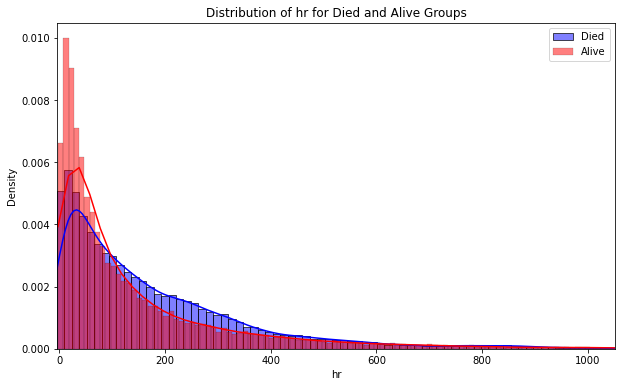

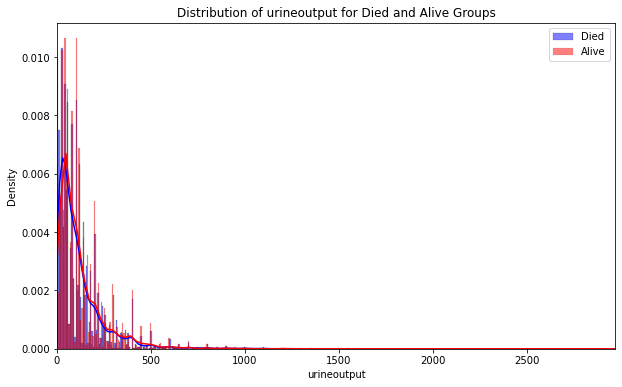

In [34]:
for column in column_names5:
    plt.figure(figsize=(10, 6))
    
    # Plot the distribution for each group
    sns.histplot(died_data5[column].dropna(), kde=True, label='Died', color='blue', stat="density")
    sns.histplot(sampled_alive_data5[column].dropna(), kde=True, label='Alive', color='red', stat="density")
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Density')
    
    # Set x-axis limits to focus on the central part of the distribution
    plt.xlim(died_data5[column].min(), died_data5[column].max())
    
    plt.legend()
    plt.show()


### ICD 9 codes for alive vs dead

In [40]:
df6 = pd.merge(pt_icu_outcome_df, icd9_diag_df, on="subject_id", how="inner")
df6 = df6[df6.filter(regex='^(?!.*_y)').columns]
df6.columns = df6.columns.str.replace('_x', '')


In [43]:
died_data6 = df6[df6['icu_expire_flag'] == 1]
alive_data6 = df6[df6['icu_expire_flag'] == 0]
column_names6 = ['icd9_code', 'short_title', 'long_title']
sampled_alive_data6 = alive_data6.sample(frac=0.01, random_state=42)

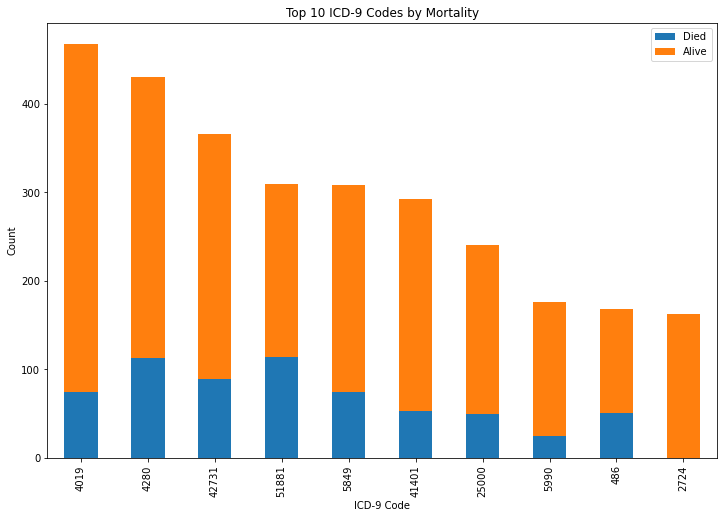

In [69]:
icd9_column = 'icd9_code'

# Count the occurrences of each unique ICD-9 code for Died and Alive groups
died_icd9_counts = died_data6[icd9_column].value_counts()
alive_icd9_counts = sampled_alive_data6[icd9_column].value_counts()

# Merge the counts into a single DataFrame
icd9_counts_df = pd.DataFrame({
    'Died': died_icd9_counts,
    'Alive': alive_icd9_counts
}).fillna(0)  # Fill NaN values with zero

# Sort by total counts (Died + Alive) in descending order
icd9_counts_df['Total'] = icd9_counts_df['Died'] + icd9_counts_df['Alive']
icd9_counts_df = icd9_counts_df.sort_values(by='Total', ascending=False)

top_n = 10
icd9_top_n_df = icd9_counts_df.head(top_n)
icd9_top_n_df[['Died', 'Alive']].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title(f'Top {top_n} ICD-9 Codes by Mortality')
plt.xlabel('ICD-9 Code')
plt.ylabel('Count')
plt.show()


### transfers for deav vs alive

In [71]:
transfers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261897 entries, 0 to 261896
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   row_id         261897 non-null  int64  
 1   subject_id     261897 non-null  int64  
 2   hadm_id        261897 non-null  int64  
 3   icustay_id     87721 non-null   float64
 4   dbsource       261656 non-null  object 
 5   eventtype      261873 non-null  object 
 6   prev_careunit  96009 non-null   object 
 7   curr_careunit  96016 non-null   object 
 8   prev_wardid    202964 non-null  float64
 9   curr_wardid    202954 non-null  float64
 10  intime         261873 non-null  object 
 11  outtime        202921 non-null  object 
 12  los            202921 non-null  float64
dtypes: float64(4), int64(3), object(6)
memory usage: 26.0+ MB


In [72]:
df7 = pd.merge(pt_icu_outcome_df, transfers_df, on="icustay_id", how="inner")
df7 = df7[df7.filter(regex='^(?!.*_y)').columns]
df7.columns = df7.columns.str.replace('_x', '')

In [73]:
died_data7 = df7[df7['icu_expire_flag'] == 1]
alive_data7 = df7[df7['icu_expire_flag'] == 0]
sampled_alive_data7 = alive_data7.sample(frac=0.01, random_state=42)

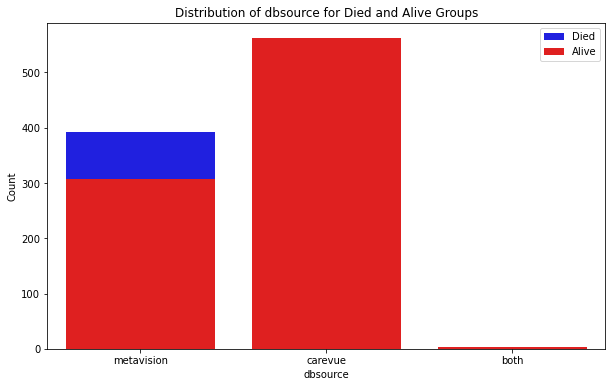

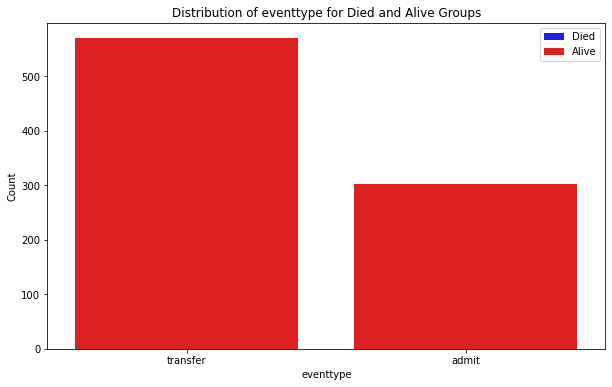

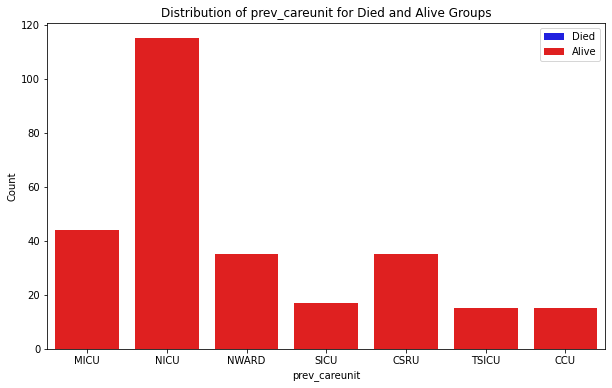

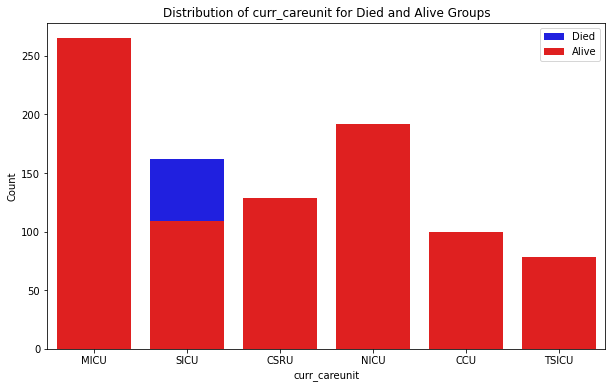

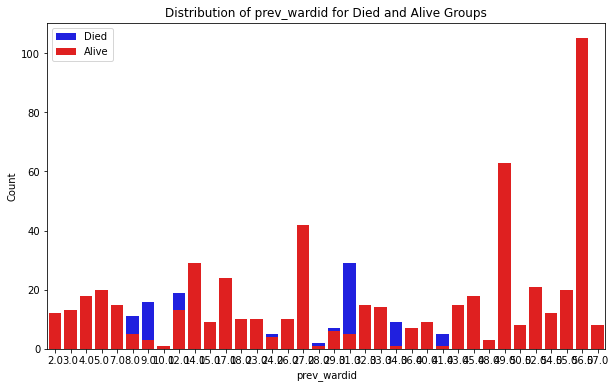

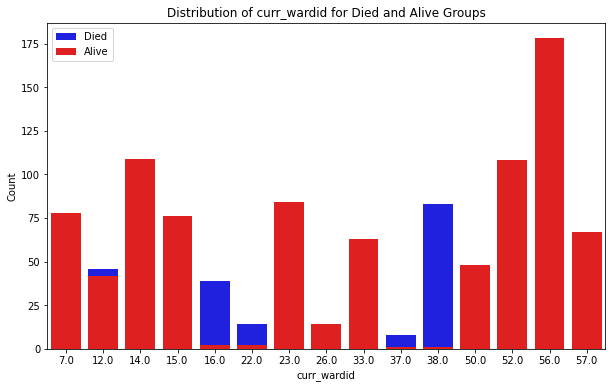

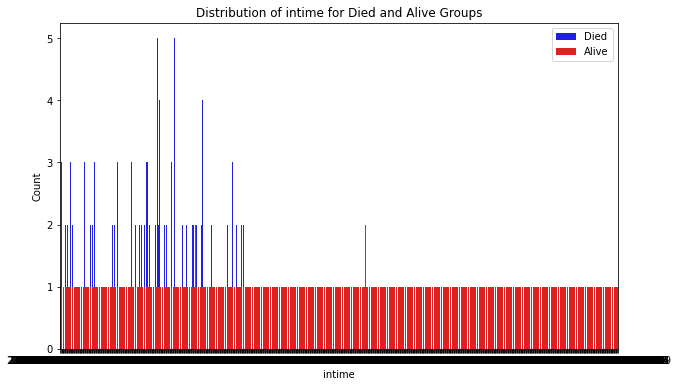

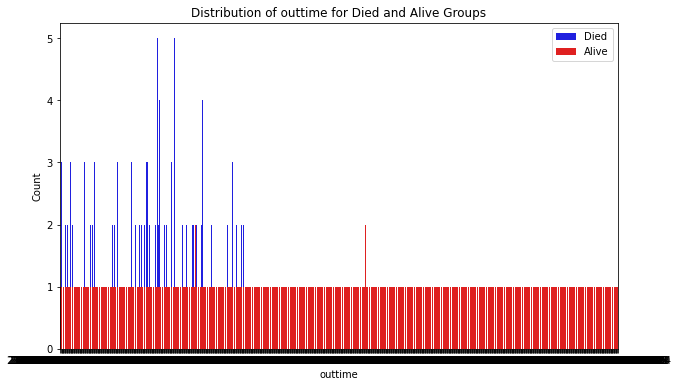

In [74]:
# EDA for categorical features
categorical_columns = ['dbsource', 'eventtype', 'prev_careunit', 'curr_careunit', 'prev_wardid','curr_wardid','intime','outtime']

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Plot the count for each category in Died and Alive groups
    sns.countplot(x=column, data=died_data7, color='blue', label='Died')
    sns.countplot(x=column, data=sampled_alive_data7, color='red', label='Alive')
    
    plt.title(f'Distribution of {column} for Died and Alive Groups')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend()
    plt.show()